
Within each cycle of active learning, you can:

1. Collect training data (original training data + your query data).

2. Train a prediction model to predict the DMS_score for each mutant (e.g., M0A).

3. Use the trained model to predict the score for all mutant in the test set.

4. Select query mutants for next round based on certain criteria. You may want to make sure you don't query the same mutant twice as you only have a limited chances of making queries in total.

# 1. Import the library

In [1]:
!pip install fair-esm -q
!pip install biopython -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 90.9 MB/s eta 0:00:00


In [2]:
import os
import json
import time
import random
from copy import deepcopy
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split
from Bio.SeqUtils.ProtParam import ProteinAnalysis

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter

import esm

# 2. Data Preparation


In [4]:
if not os.path.exists('sequence.fasta'):
    !wget -q --show-progress https://raw.githubusercontent.com/liuxuanzhang718/MLBHackathon/main/Hackathon_data/sequence.fasta
    !wget -q --show-progress https://raw.githubusercontent.com/liuxuanzhang718/MLBHackathon/main/Hackathon_data/train.csv
    !wget -q --show-progress https://raw.githubusercontent.com/liuxuanzhang718/MLBHackathon/main/Hackathon_data/test.csv

In [5]:
with open('sequence.fasta', 'r') as f:
    data = f.readlines()
sequence_wt = data[1].strip()
print(f"Wild-type sequence length: {len(sequence_wt)}")
print(f"Wild-type sequence: {sequence_wt[:50]}...")  # Print the first 50 characters

Wild-type sequence length: 656
Wild-type sequence: MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMR...


In [6]:
def get_mutated_sequence(mut, sequence_wt):
  wt, pos, mt = mut[0], int(mut[1:-1]), mut[-1]

  sequence = deepcopy(sequence_wt)

  return sequence[:pos]+mt+sequence[pos+1:]

In [7]:
# Compute physicochemical features
def compute_physicochemical_features(seq):
    analysis = ProteinAnalysis(seq)
    return [
        analysis.gravy(),
        analysis.isoelectric_point(),
        analysis.molecular_weight(),
        analysis.aromaticity()
    ]

In [8]:
# Load the original training data
df_all = pd.read_csv('train.csv')

# Split the data into training and validation sets (e.g., 80% training, 20% validation)
df_train, df_val = train_test_split(df_all, test_size=0.2, random_state=0)

# Preprocess the training set: add wild-type sequence, mutated sequence, and mutation position
df_train['wt_seq'] = sequence_wt
df_train['mut_seq'] = df_train['mutant'].apply(lambda x: get_mutated_sequence(x, sequence_wt))
df_train['pos'] = df_train['mutant'].apply(lambda x: int(x[1:-1]))
print("Training set sample:")
print(df_train.head())

# Apply the same preprocessing to the validation set
df_val['wt_seq'] = sequence_wt
df_val['mut_seq'] = df_val['mutant'].apply(lambda x: get_mutated_sequence(x, sequence_wt))
df_val['pos'] = df_val['mutant'].apply(lambda x: int(x[1:-1]))
print("Validation set sample:")
print(df_val.head())


Training set sample:
     mutant  DMS_score                                             wt_seq  \
761   Y296E     0.2078  MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...   
597   P253Q     0.1447  MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...   
317   I191D     0.1725  MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...   
860   C305Q     0.5083  MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...   
1078  R334N     0.5922  MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...   

                                                mut_seq  pos  
761   MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...  296  
597   MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...  253  
317   MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...  191  
860   MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...  305  
1078  MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...  334  
Validation set sample:
     mutant  DMS_score                                             wt_seq  \
1014  F319M     0.5501  MVNEARGNSSLNPC

### Load Dataset

ProteinDataset without Physico Feature

In [ ]:
# Define dataset class
class ProteinDatasetDMS(Dataset):
    def __init__(self, df):
        self.df = df
        _, self.esm_alphabet = esm.pretrained.esm2_t12_35M_UR50D()
        self.esm_batch_converter = self.esm_alphabet.get_batch_converter()

    def __getitem__(self, idx):
        wt_seq = self.df.iloc[idx]['wt_seq']
        mut_seq = self.df.iloc[idx]['mut_seq']
        pos = self.df.iloc[idx]['pos']
        score = self.df.iloc[idx].get('DMS_score', 0.0)  # Return 0.0 when the test set has no score
        _, _, tokens_wt = self.esm_batch_converter([('', wt_seq)])
        _, _, tokens_mut = self.esm_batch_converter([('', mut_seq)])
        return tokens_wt[0], tokens_mut[0], pos, torch.tensor([score], dtype=torch.float)

    def __len__(self):
        return len(self.df)

# Define collate function
def collate_fn(batch):
    tokens_wt_list, tokens_mut_list, pos_list, scores_list = zip(*batch)
    tokens_wt_batch = torch.stack(tokens_wt_list, dim=0)
    tokens_mut_batch = torch.stack(tokens_mut_list, dim=0)
    pos_batch = torch.tensor(pos_list, dtype=torch.long)
    scores_batch = torch.stack(scores_list, dim=0)
    return tokens_wt_batch, tokens_mut_batch, pos_batch, scores_batch


#### ProteinDataset with Physico Feature

In [ ]:
class ProteinDatasetDMS(Dataset):
    def __init__(self, df):
        self.df = df
        # Initialize ESM tokenizer
        _, self.esm_alphabet = esm.pretrained.esm2_t12_35M_UR50D()
        self.esm_batch_converter = self.esm_alphabet.get_batch_converter()

        # Pre-compute physicochemical features for each sample and calculate mean and standard deviation
        physico_list = []
        for idx in range(len(df)):
            mut_seq = df.iloc[idx]['mut_seq']
            features = compute_physicochemical_features(mut_seq)
            physico_list.append(features)
        physico_array = np.array(physico_list, dtype=np.float32)  # shape: (N, 4)
        self.physico_mean = physico_array.mean(axis=0)  # shape: (4,)
        self.physico_std = physico_array.std(axis=0)    # shape: (4,)
        # Prevent standard deviation from being zero
        self.physico_std[self.physico_std == 0] = 1.0

    def __getitem__(self, idx):
        wt_seq = self.df.iloc[idx]['wt_seq']
        mut_seq = self.df.iloc[idx]['mut_seq']
        pos = self.df.iloc[idx]['pos']
        score = self.df.iloc[idx].get('DMS_score', 0.0)  # Return 0.0 if no score is available

        # Get ESM tokens (returns a tuple, extract the tokens)
        _, _, tokens_wt = self.esm_batch_converter([('', wt_seq)])
        _, _, tokens_mut = self.esm_batch_converter([('', mut_seq)])

        # Compute additional physicochemical features (for the mutated sequence)
        physico_features = compute_physicochemical_features(mut_seq)
        # Normalize the features
        physico_features = (np.array(physico_features, dtype=np.float32) - self.physico_mean) / self.physico_std

        return (tokens_wt[0],
                tokens_mut[0],
                pos,
                torch.tensor(physico_features, dtype=torch.float),  # shape: (4,)
                torch.tensor([score], dtype=torch.float))

    def __len__(self):
        return len(self.df)

# Modify the collate function to ensure additional features are correctly stacked
def collate_fn(batch):
    tokens_wt_list, tokens_mut_list, pos_list, physico_list, scores_list = zip(*batch)
    tokens_wt_batch = torch.stack(tokens_wt_list, dim=0)
    tokens_mut_batch = torch.stack(tokens_mut_list, dim=0)
    pos_batch = torch.tensor(pos_list, dtype=torch.long)
    physico_batch = torch.stack(physico_list, dim=0)  # shape: (batch_size, 4)
    scores_batch = torch.stack(scores_list, dim=0)
    return tokens_wt_batch, tokens_mut_batch, pos_batch, physico_batch, scores_batch


In [ ]:
dataset_train = ProteinDatasetDMS(df_train)
dataset_val = ProteinDatasetDMS(df_val)

train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(dataset_val, batch_size=16, shuffle=False, collate_fn=collate_fn)

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t12_35M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t12_35M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t12_35M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t12_35M_UR50D-contact-regression.pt


# 3. Model Architecture

Inspired by: https://www.biorxiv.org/content/10.1101/2025.02.03.635741v1.full.pdf

Main Points:

- The scaling law does not apply well to downstream tasks; a 35M model can achieve a good balance between performance and efficiency.

- LoRA and full fine-tuning yield similar results. The authors found that freezing the first 10 layers and only adjusting the parameters of the last two layers along with the regression head achieves better performance.


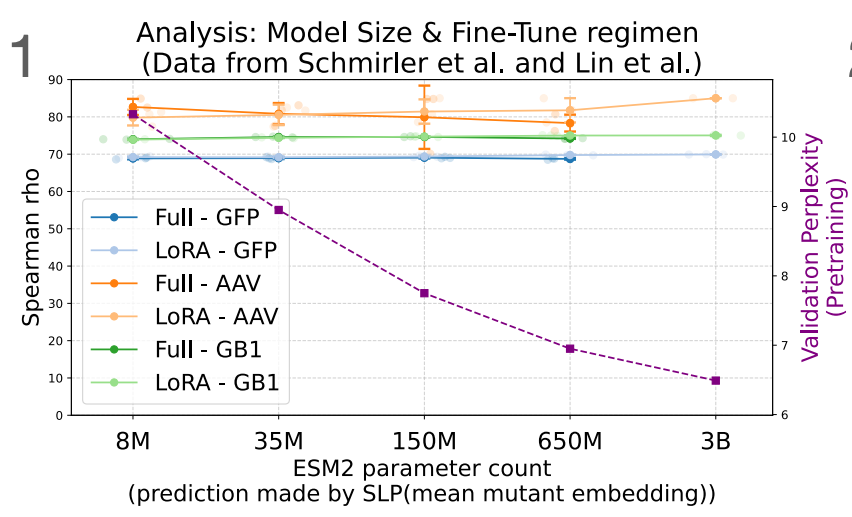

In [ ]:
class ESMEncoder(nn.Module):
    """
    Extract per-residue representations of protein sequences using a pretrained ESM model,
    and freeze parameters of the first few layers.
    """
    def __init__(self, model_name='esm2_t12_35M_UR50D', freeze_up_to=10):
        super().__init__()
        self.esm_model, _ = esm.pretrained.__dict__[model_name]()
        # Freeze the first `freeze_up_to` layers
        for i in range(freeze_up_to):
            for param in self.esm_model.layers[i].parameters():
                param.requires_grad = False

    def forward(self, tokens):
        # Get representations from the last layer
        out = self.esm_model(tokens, repr_layers=[self.esm_model.num_layers], return_contacts=False)
        return out["representations"][self.esm_model.num_layers]

class RegressionHead(nn.Module):
    """
    Regression head: Concatenate representations at the mutation site from wild-type
    and mutant sequences, and predict mutation effect score using an MLP.
    """
    def __init__(self, embedding_dim=480, hidden_dim=256, dropout_rate=0.2):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim * 2, hidden_dim),  # Input dimension is 2 * embedding_dim after concatenation
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, esm_rep_wt, esm_rep_mut, positions):
        """
        Args:
            esm_rep_wt: Representation of wild-type sequence, shape (batch_size, seq_length, embedding_dim)
            esm_rep_mut: Representation of mutant sequence, same shape
            positions: Mutation position index for each sample, shape (batch_size,), type long
        Returns:
            Predicted scores, shape (batch_size,)
        """
        batch_size = esm_rep_mut.size(0)
        # Ensure positions are on the correct device
        positions = positions.to(esm_rep_mut.device)
        # Generate batch indices using torch.arange
        batch_idx = torch.arange(batch_size, device=esm_rep_mut.device)
        # Extract features at the mutation positions from both wild-type and mutant, then concatenate
        wt_feature = esm_rep_wt[batch_idx, positions]    # (batch_size, embedding_dim)
        mut_feature = esm_rep_mut[batch_idx, positions]  # (batch_size, embedding_dim)
        features = torch.cat([wt_feature, mut_feature], dim=1)  # (batch_size, 2 * embedding_dim)
        # Output scalar predictions through MLP
        return self.mlp(features).squeeze(1)

class ESMDMSModel(nn.Module):
    """
    Full model: Encode wild-type and mutant sequences separately,
    then use regression head to predict the difference.
    Inputs:
        tokens_wt, tokens_mut: Token encodings for wild-type and mutant sequences
        positions: Index of mutation position for each sample
    Output:
        Predicted mutation effect scores (shape: (batch_size,))
    """
    def __init__(self):
        super().__init__()
        self.encoder = ESMEncoder()
        self.regressor = RegressionHead()

    def forward(self, tokens_wt, tokens_mut, positions):
        esm_rep_wt = self.encoder(tokens_wt)
        esm_rep_mut = self.encoder(tokens_mut)
        return self.regressor(esm_rep_wt, esm_rep_mut, positions)


## Version 2 basic model with bio
从biopython库中导入理化性质，作为特征添加

In [ ]:
class ESMEncoder(nn.Module):
    def __init__(self, model_name='esm2_t12_35M_UR50D', freeze_up_to=10):
        super().__init__()
        self.esm_model, _ = esm.pretrained.__dict__[model_name]()
        # Freeze the first `freeze_up_to` layers
        for i in range(freeze_up_to):
            for param in self.esm_model.layers[i].parameters():
                param.requires_grad = False

    def forward(self, tokens):
        out = self.esm_model(tokens, repr_layers=[self.esm_model.num_layers], return_contacts=False)
        return out["representations"][self.esm_model.num_layers]

class RegressionHead(nn.Module):
    def __init__(self, embedding_dim=480, physico_dim=4, hidden_dim=256, dropout_rate=0.2):
        super().__init__()
        # Input dimension: wild-type and mutant representations at mutation site (480*2) + physicochemical features (physico_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embedding_dim * 2 + physico_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, esm_rep_wt, esm_rep_mut, positions, physico_features):
        batch_size = esm_rep_mut.size(0)
        positions = positions.to(esm_rep_mut.device)
        batch_idx = torch.arange(batch_size, device=esm_rep_mut.device)
        # Extract the representation at the mutation position for each sample
        wt_feature = esm_rep_wt[batch_idx, positions]    # (batch_size, embedding_dim)
        mut_feature = esm_rep_mut[batch_idx, positions]  # (batch_size, embedding_dim)
        # Concatenate wild-type, mutant representations, and additional physicochemical features
        features = torch.cat([wt_feature, mut_feature, physico_features], dim=1)
        return self.mlp(features).squeeze(1)

class ESMDMSModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = ESMEncoder()
        self.regressor = RegressionHead()

    def forward(self, tokens_wt, tokens_mut, positions, physico_features):
        esm_rep_wt = self.encoder(tokens_wt)
        esm_rep_mut = self.encoder(tokens_mut)
        return self.regressor(esm_rep_wt, esm_rep_mut, positions, physico_features)


## Training and Evaluation Part

In [ ]:
class TrainingManager:
    def __init__(self, model: nn.Module, config: dict, experiment_name: str, base_dir: str = "./experiments"):
        """
        Args:
            model: The model to be trained (end-to-end model)
            config: Configuration dictionary, should contain at least the following fields:
                - device: "cuda" or "cpu"
                - epochs: Total number of training epochs
                - lr: Learning rate (for AdamW)
                - steps_per_epoch: Number of steps per epoch (used in OneCycleLR scheduler)
                - weight_decay: (optional) Weight decay for AdamW
            experiment_name: Experiment name, used to distinguish log directories when comparing different models
            base_dir: Root directory to store experiment results
        """
        self.device = torch.device(config['device'])
        self.model = model.to(self.device)
        self.config = config
        self.experiment_name = f"{experiment_name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

        # Define MSE loss
        self.criterion = nn.MSELoss()
        # Use AdamW optimizer
        self.optimizer = AdamW(self.model.parameters(),
                               lr=config['lr'],
                               weight_decay=config.get('weight_decay', 0.0))
        # Use OneCycleLR learning rate scheduler
        self.scheduler = OneCycleLR(self.optimizer,
                                    max_lr=config['lr'],
                                    steps_per_epoch=config['steps_per_epoch'],
                                    epochs=config['epochs'])
        # Scaler required for mixed precision training
        self.scaler = torch.cuda.amp.GradScaler()

        self._setup_directories(base_dir)
        self.writer = SummaryWriter(log_dir=str(self.log_dir))

    def _setup_directories(self, base_dir: str):
        """Create directories to save logs, models, and config files"""
        self.exp_dir = Path(base_dir) / self.experiment_name
        self.log_dir = self.exp_dir / "logs"
        self.model_dir = self.exp_dir / "models"
        for d in [self.exp_dir, self.log_dir, self.model_dir]:
            d.mkdir(parents=True, exist_ok=True)
        # Save config file
        with open(self.exp_dir / "config.json", "w") as f:
            json.dump(self.config, f, indent=4)

    def train_epoch(self, train_loader, epoch: int):
        self.model.train()
        total_loss = 0
        for batch in train_loader:
            # Assume batch is: tokens_wt, tokens_mut, pos, scores
            batch = [b.to(self.device) if isinstance(b, torch.Tensor) else b for b in batch]
            inputs = batch[:-1]    # Model inputs (adjust according to your model, e.g. tokens_wt, tokens_mut, pos, etc.)
            labels = batch[-1].float().squeeze()  # Score labels

            self.optimizer.zero_grad()
            with torch.amp.autocast(device_type='cuda'):
                predictions = self.model(*inputs)
                loss = self.criterion(predictions.squeeze(), labels)
            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()
            self.scheduler.step()

            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        self.writer.add_scalar("Loss/train", avg_loss, epoch)
        return avg_loss

    def evaluate(self, val_loader, epoch: int):
        self.model.eval()
        total_loss = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch in val_loader:
                batch = [b.to(self.device) if isinstance(b, torch.Tensor) else b for b in batch]
                inputs = batch[:-1]
                labels = batch[-1].float().squeeze()
                predictions = self.model(*inputs)
                loss = self.criterion(predictions.squeeze(), labels)
                total_loss += loss.item()
                all_preds.extend(predictions.detach().cpu().numpy().squeeze())
                all_labels.extend(labels.detach().cpu().numpy().squeeze())
        avg_loss = total_loss / len(val_loader)
        # Compute correlation metrics
        pearson_corr = pearsonr(all_labels, all_preds)[0]
        spearman_corr = spearmanr(all_labels, all_preds)[0]
        self.writer.add_scalar("Loss/val", avg_loss, epoch)
        self.writer.add_scalar("Metrics/val_pearson", pearson_corr, epoch)
        self.writer.add_scalar("Metrics/val_spearman", spearman_corr, epoch)

        print(f"Epoch {epoch}: Val Loss {avg_loss:.4f}, Pearson {pearson_corr:.4f}, Spearman {spearman_corr:.4f}")
        return avg_loss, pearson_corr, spearman_corr

    def save_checkpoint(self, epoch: int, filename: str = None):
        if filename is None:
            filename = f"checkpoint_epoch_{epoch}.pt"
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'config': self.config,
        }
        save_path = self.model_dir / filename
        torch.save(checkpoint, save_path)
        print(f"Saved checkpoint to {save_path}")

    def load_checkpoint(self, filename: str):
        checkpoint_path = Path("/content/") / filename
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        print(f"Loaded checkpoint from {checkpoint_path}")
        return checkpoint

    def train(self, train_loader, val_loader=None):
        best_val_loss = float('inf')
        for epoch in range(self.config['epochs']):
            start_time = time.time()
            train_loss = self.train_epoch(train_loader, epoch)
            if val_loader is not None:
                val_loss, pearson_corr, spearman_corr = self.evaluate(val_loader, epoch)
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    self.save_checkpoint(epoch, filename="best_model.pt")
            elapsed = time.time() - start_time
            print(f"Epoch {epoch} completed in {elapsed:.2f} seconds")
        self.writer.close()


### Begin Training

In [ ]:
# Instantiate the model
model = ESMDMSModel()

# Configure training parameters
config = {
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "epochs": 50,
    "lr": 1e-4,
    "steps_per_epoch": len(train_loader),
    "weight_decay": 0.001,
}

# Create an instance of the training manager
manager = TrainingManager(model, config, experiment_name="ESMDMSModel")

# Start training
manager.train(train_loader, val_loader)

<ipython-input-13-df02e43d12c5>:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


Epoch 0: Val Loss 0.1029, Pearson -0.2235, Spearman -0.3221
Saved checkpoint to experiments/ESMDMSModel_20250403_153120/models/best_model.pt
Epoch 0 completed in 32.33 seconds
Epoch 1: Val Loss 0.0515, Pearson -0.0690, Spearman -0.1304
Saved checkpoint to experiments/ESMDMSModel_20250403_153120/models/best_model.pt
Epoch 1 completed in 30.45 seconds
Epoch 2: Val Loss 0.0410, Pearson 0.2262, Spearman 0.2668
Saved checkpoint to experiments/ESMDMSModel_20250403_153120/models/best_model.pt
Epoch 2 completed in 30.45 seconds
Epoch 3: Val Loss 0.0355, Pearson 0.3995, Spearman 0.4051
Saved checkpoint to experiments/ESMDMSModel_20250403_153120/models/best_model.pt
Epoch 3 completed in 30.34 seconds
Epoch 4: Val Loss 0.0307, Pearson 0.4738, Spearman 0.4140
Saved checkpoint to experiments/ESMDMSModel_20250403_153120/models/best_model.pt
Epoch 4 completed in 30.37 seconds
Epoch 5: Val Loss 0.0283, Pearson 0.4870, Spearman 0.5168
Saved checkpoint to experiments/ESMDMSModel_20250403_153120/models/b

# 4. Active Learning


In [ ]:
from scipy.stats import norm

# 1. Construct the candidate dataset (similar to ProteinDatasetDMS, but without labels)
class CandidateProteinDataset(Dataset):
    def __init__(self, df, sequence_wt, physico_mean, physico_std, esm_alphabet):
        """
        df: DataFrame containing candidate mutations, must include 'mutant', 'wt_seq', 'mut_seq', 'pos'
        """
        self.df = df.copy()
        self.sequence_wt = sequence_wt
        self.physico_mean = physico_mean
        self.physico_std = physico_std
        self.esm_alphabet = esm_alphabet
        self.esm_batch_converter = self.esm_alphabet.get_batch_converter()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        wt_seq = row['wt_seq']
        mut_seq = row['mut_seq']
        pos = row['pos']
        # Get ESM tokens
        _, _, tokens_wt = self.esm_batch_converter([('', wt_seq)])
        _, _, tokens_mut = self.esm_batch_converter([('', mut_seq)])
        # Compute physicochemical features and normalize
        physico_features = compute_physicochemical_features(mut_seq)
        physico_features = (np.array(physico_features, dtype=np.float32) - self.physico_mean) / self.physico_std
        return {
            'mutant': row['mutant'],
            'tokens_wt': tokens_wt[0],
            'tokens_mut': tokens_mut[0],
            'pos': pos,
            'physico': torch.tensor(physico_features, dtype=torch.float)
        }

def candidate_collate_fn(batch):
    tokens_wt_list = [item['tokens_wt'] for item in batch]
    tokens_mut_list = [item['tokens_mut'] for item in batch]
    pos_list = [item['pos'] for item in batch]
    physico_list = [item['physico'] for item in batch]
    mutant_list = [item['mutant'] for item in batch]
    tokens_wt_batch = torch.stack(tokens_wt_list, dim=0)
    tokens_mut_batch = torch.stack(tokens_mut_list, dim=0)
    pos_batch = torch.tensor(pos_list, dtype=torch.long)
    physico_batch = torch.stack(physico_list, dim=0)
    return tokens_wt_batch, tokens_mut_batch, pos_batch, physico_batch, mutant_list


# 2. Define the ActiveLearningManager module
class ActiveLearningManager:
    def __init__(self, model, candidate_df, training_df, sequence_wt, physico_mean, physico_std, esm_alphabet, device):
        """
        model: The currently trained model (e.g., ESMDMSModel)
        candidate_df: Unlabeled candidate DataFrame (e.g., constructed from test.csv, must include 'mutant', 'wt_seq', 'mut_seq', 'pos')
        training_df: Labeled training set DataFrame
        sequence_wt: Wild-type sequence string
        physico_mean, physico_std: Mean and std of physicochemical features computed from the training set (for normalization)
        esm_alphabet: Object for ESM tokenization
        device: Computing device
        """
        self.model = model
        self.candidate_df = candidate_df.copy()
        self.training_df = training_df.copy()
        self.sequence_wt = sequence_wt
        self.physico_mean = physico_mean
        self.physico_std = physico_std
        self.esm_alphabet = esm_alphabet
        self.device = device
        self.query_round = 0

    def run_inference_on_candidates(self, batch_size=16):
        """
        Perform inference on the candidate set and return a list of (mutant, prediction)
        """
        dataset = CandidateProteinDataset(self.candidate_df, self.sequence_wt, self.physico_mean, self.physico_std, self.esm_alphabet)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=candidate_collate_fn)
        self.model.eval()
        predictions = []
        mutant_ids = []
        with torch.no_grad():
            for tokens_wt, tokens_mut, pos_batch, physico_batch, mutant_list in loader:
                tokens_wt = tokens_wt.to(self.device)
                tokens_mut = tokens_mut.to(self.device)
                pos_batch = pos_batch.to(self.device)
                physico_batch = physico_batch.to(self.device)
                outputs = self.model(tokens_wt, tokens_mut, pos_batch, physico_batch)
                predictions.extend(outputs.cpu().numpy().tolist())
                mutant_ids.extend(mutant_list)
        return list(zip(mutant_ids, predictions))

    def run_MCD_inference_on_candidates(self, n_samples=5, batch_size=16):
        """
        Perform inference with Monte Carlo Dropout and return list [(mutant, prediction), ...]
        Compared with run_inference_on_candidates():
        1 - Uses Monte Carlo Dropout to predict the candidate set multiple times
        2 - Enables dropout by setting model to train mode instead of eval
        """
        dataset = CandidateProteinDataset(self.candidate_df, self.sequence_wt, self.physico_mean, self.physico_std, self.esm_alphabet)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=candidate_collate_fn)

        all_preds = {}

        for _ in range(n_samples):
            print(f"Current round: sample {_}")
            self.model.train()  # Enable dropout
            with torch.no_grad():
                for tokens_wt, tokens_mut, pos_batch, physico_batch, mutant_list in loader:
                    tokens_wt = tokens_wt.to(self.device)
                    tokens_mut = tokens_mut.to(self.device)
                    pos_batch = pos_batch.to(self.device)
                    physico_batch = physico_batch.to(self.device)
                    outputs = self.model(tokens_wt, tokens_mut, pos_batch, physico_batch)
                    preds = outputs.cpu().numpy().tolist()

                    for mutant, pred in zip(mutant_list, preds):
                        all_preds.setdefault(mutant, []).append(pred)

        return [(mutant, prediction) for mutant, prediction in all_preds.items()]

# Selection strategies for active learning
    def select_query_samples(self, num_query=100, strategy='uncertainty'):
        """
        Select candidate samples based on the specified strategy.

        The following strategies use single-pass prediction:
        - 'uncertainty': Select predictions closest to 0.5 (assuming fitness is in [0, 1], 0.5 is most uncertain)
        - 'greedy': Select the highest predicted values
        - 'random': Randomly select samples

        The following strategies use Monte Carlo Dropout, i.e., multiple forward passes with dropout enabled:
        - 'mcd_uncertainty': Select mutants with the highest prediction standard deviation (most uncertain)
        - 'ucb' (Upper Confidence Bound): Select mutants with the highest mean + std (optimistic strategy)
        - 'ei' (Expected Improvement): Select mutants with the highest standardized expected improvement (more precision-focused)

        Returns a list of selected mutant identifiers
        """
        if strategy in ['mcd_uncertainty', 'ucb', 'ei']:
            pred_results = self.run_MCD_inference_on_candidates()
            scored_sorted = []
            for mutant, preds in pred_results:
                preds = np.array(preds)
                mean = preds.mean()
                std = preds.std()

                if strategy == 'mcd_uncertainty':
                    scored = std
                elif strategy == 'ucb':
                    scored = mean + std
                elif strategy == 'ei':
                    best = max([np.mean(p) for _, p in pred_results])
                    z = (mean - best) / (std + 1e-8)
                    scored = (mean - best) * norm.cdf(z) + std * norm.pdf(z)

                scored_sorted.append((mutant, scored))

            scored_sorted.sort(key=lambda x: x[1], reverse=True)
            selected = [mut for mut, _ in scored_sorted[:num_query]]

        else:
            pred_results = self.run_inference_on_candidates()
            if strategy == 'uncertainty':
                scored = [(mut, abs(pred - 0.5)) for mut, pred in pred_results]
                scored_sorted = sorted(scored, key=lambda x: x[1])  # Prioritize smallest difference
                selected = [mut for mut, _ in scored_sorted[:num_query]]
            elif strategy == 'greedy':
                scored_sorted = sorted(pred_results, key=lambda x: x[1], reverse=True)
                selected = [mut for mut, _ in scored_sorted[:num_query]]
            elif strategy == 'random':
                selected = [mut for mut, _ in random.sample(pred_results, num_query)]
            else:
                raise ValueError("Unsupported strategy")
        return selected

    def output_query_file(self, selected_mutants, filename='query.txt'):
        """
        Write selected mutants to a query.txt file, one mutant ID per line
        """
        with open(filename, 'w') as f:
            for mutant in selected_mutants:
                f.write(mutant + "\n")
        print(f"Generated query file {filename} with {len(selected_mutants)} mutants.")

    def update_training_set(self, new_labels_csv):
        """
        Update the training set:
         - Read the new file new_labels_csv (should include columns: mutant, DMS_score)
         - Merge it with candidate info (wt_seq, mut_seq, pos)
         - Append to the training set and remove these from the candidate set
        """
        new_data = pd.read_csv(new_labels_csv)
        # Merge candidate info
        new_data = new_data.merge(self.candidate_df[['mutant', 'wt_seq', 'mut_seq', 'pos']], on='mutant', how='left')
        self.training_df = pd.concat([self.training_df, new_data], ignore_index=True)
        print(f"Added {len(new_data)} new samples to the training set.")
        # Remove queried samples from the candidate set
        self.candidate_df = self.candidate_df[~self.candidate_df['mutant'].isin(new_data['mutant'])]
        self.query_round += 1
        print(f"Updated query round to {self.query_round}.")

    def get_training_data(self):
        return self.training_df

    def get_candidate_data(self):
        return self.candidate_df


In [ ]:
# Load candidate set (assume test.csv contains only unlabeled mutations)
df_candidate = pd.read_csv('test.csv')
df_candidate['wt_seq'] = sequence_wt
df_candidate['mut_seq'] = df_candidate['mutant'].apply(lambda x: get_mutated_sequence(x, sequence_wt))
df_candidate['pos'] = df_candidate['mutant'].apply(lambda x: int(x[1:-1]))

# dataset_train is an instance of ProteinDatasetDMS
esm_alphabet = dataset_train.esm_alphabet
physico_mean = dataset_train.physico_mean
physico_std = dataset_train.physico_std

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
active_manager = ActiveLearningManager(
    model=model,
    candidate_df=df_candidate,
    training_df=df_train,
    sequence_wt=sequence_wt,
    physico_mean=physico_mean,
    physico_std=physico_std,
    esm_alphabet=esm_alphabet,
    device=device
)


Each round is defined as selecting mutations followed by retraining, with a total of 3 rounds.

### Round 1

In [ ]:
selected_mutants_round_1 = active_manager.select_query_samples(num_query=100, strategy='mcd_uncertainty')
active_manager.output_query_file(selected_mutants_round_1, filename='query_round1.txt')

Current round: sample 0
Current round: sample 1
Current round: sample 2
Current round: sample 3
Current round: sample 4
生成了查询文件 query_round1.txt，共 100 个突变。


⚠️⚠️⚠️ Prepare the following 3 files:

- query_round1.txt
(!! Before submitting to Gradescope, make sure to rename it to "query.txt")
- GroupName.txt

- APIKey.txt

✅ First, submit to Gradescope: Hackathon-FormatCheck
Confirm that the submission format is correct.

✅ Then, submit to Gradescope: Hackathon-ActiveLearning
Wait for the results to return, and you will receive a new labeled data file: new_labels_round1.csv
(Download new_labels_round1.csv to the current directory)

In [ ]:
query_data = """
mutant,DMS_score,sequence
S17E,0.8036050797902574,MVNEARGNSSLNPCLEGEASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E42K,0.9597208147822618,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHKRLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
R43T,0.8829790904738913,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHETLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E46C,0.7168010827605198,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLRCKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
K47H,0.6850392946954348,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREHMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
R49W,0.8231396293088934,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMWRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
R78E,0.11726255853104639,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISEFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
F79H,0.4827707242878138,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRHDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
P96W,0.7739551467203301,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHWAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
D99W,0.784494080984365,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGWPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
C119H,0.9439529876210878,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYHGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
C129V,0.6538956833224395,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTVCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
R133Y,0.8185149144047614,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQYLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
H140A,0.9167778487282647,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGALHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
F171Y,0.900217625490198,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGYNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
Y173K,0.5504090862817417,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNKAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
L177Y,0.3825523981882377,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDYVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
V178Y,0.05220588540879909,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLYKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
D209A,0.9534759252446907,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEAALKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
L210D,0.192491510119701,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADDKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
T226W,0.023478352508177133,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIIWQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
R237G,0.9020193137918313,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFGFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
R265L,0.873094045371767,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLLQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E274V,0.8067656867738474,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLVVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
Q277I,0.7675044649018031,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPIEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
I283H,0.020728031476451136,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVHEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
R294S,0.7909806363532376,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAISNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
L300P,0.03447219578839322,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIEPAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
K333T,0.23298879712575557,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLTRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
W348N,0.507843638364986,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPNALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
K355D,0.7070475995422474,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPDRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
R362C,0.34291723836759125,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVCPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
Y375R,0.8394402834108539,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIRRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
R376T,0.3656345750871293,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYTTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
N385K,0.7699877994041329,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPKGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
N385M,0.8529592217008871,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPMGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E398S,0.8860153410902523,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGSLKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
K400G,0.8870057840762389,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELGDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
Y406I,0.8472861564763063,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFILKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
K413G,0.959572505450484,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPGEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E415R,0.9107906519916377,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKERLLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
W420I,0.9408968940248699,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMIGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E428Q,0.9642769235578251,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEQSVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E428M,0.8616791792774225,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEMSVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
S429I,0.9667957686399323,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEEIVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
S429N,0.9078360533912947,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEENVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E432G,0.7798086252904468,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFGVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
V433D,0.8257783487862432,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEDFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
V433L,0.9233777977506623,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFELFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
F434H,0.7379954622075522,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVHVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
F434A,0.7076705410344605,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVAVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
G440M,0.8001701378711044,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSMEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
G446T,0.7751014035059818,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNTHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
K448D,0.3940587229368781,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHDVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
W454P,0.8359983585532351,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPPNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
P458L,0.8993862176212387,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDELLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
L465V,0.7757207686621815,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSVLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
R472M,0.8488246746223101,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLMVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
R472H,0.9032191092921856,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLHVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
G477Y,0.9485189180413754,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQYILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
I487G,0.9143873600124148,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNGNGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
K490I,0.9202168134804736,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGIPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
G498D,0.9068839848663958,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVDWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
P501W,0.9292072793869869,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGWSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
V506K,0.7754825807158064,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYKFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
Q508G,0.9375945145049264,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFGKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
K509V,0.8746561528930831,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQVAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
A510E,0.8553742675422185,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKEYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
Y511V,0.9060471602606174,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAVLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
F514V,0.8686730584204355,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEVFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
F514T,0.6271191477510947,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLETFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
T516L,0.9060150476858214,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFLSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
L524R,0.31252239391394376,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEARLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
Y531L,0.9213975088610634,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKLELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E532Q,0.9534096663774602,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYQLRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
L533K,0.8020566969423933,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYEKRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
N541K,0.7690572562137822,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVKVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
N541L,0.7215698976026297,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVLVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
K543L,0.8685651860997009,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVLGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
N546G,0.8099600104344582,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGEGITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
N546T,0.8375629293864609,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGETITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
W560K,0.6717053277731807,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTKGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
F563R,0.8013687814824924,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIRPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
P564N,0.8945452101243031,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFNGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
R566I,0.8944181611778808,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGIEIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
V574K,0.830404101967336,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVKDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
D575C,0.9149207180600808,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVCPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
W582D,0.8259763886670952,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFDKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
W590T,0.9545426725684254,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALTIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
K596P,0.9239339193057801,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGPLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E601Q,0.8502226319498427,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEQSPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
V621T,0.7201980239956085,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLTDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
C630G,0.9037342103185876,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNGLWQVVEDTLELLNRPTQNARETEAP
L631M,0.8515244752323424,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCMWQVVEDTLELLNRPTQNARETEAP
W632H,0.6295160325906399,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLHQVVEDTLELLNRPTQNARETEAP
W632E,0.6687413975267006,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLEQVVEDTLELLNRPTQNARETEAP
V635M,0.9656133665563787,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVMEDTLELLNRPTQNARETEAP
R650A,0.6948865940584852,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNAAETEAP
R650T,0.6289052844573151,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNATETEAP
T652Q,0.72286963805767,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNAREQEAP
"""

with open("new_labels_round1.csv", "w") as f:
    f.write(query_data)

In [ ]:
active_manager.update_training_set(new_labels_csv='new_labels_round1.csv')
df_train_updated_round_1 = active_manager.get_training_data()

In [ ]:
dataset_train_updated_round_1 = ProteinDatasetDMS(df_train_updated_round_1)
train_loader_updated_round_1 = DataLoader(dataset_train_updated_round_1, batch_size=16, shuffle=True, collate_fn=collate_fn)

# Create a new model instance for fine-tuning
model_round1 = ESMDMSModel()

# Define the updated config, ensure steps_per_epoch is set correctly based on the DataLoader length
config_round1 = {
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "epochs": 20,
    "lr": 1e-4,
    "steps_per_epoch": len(train_loader_updated_round_1),
    "weight_decay": 0.01,
}

# Create a TrainingManager instance for the fine-tuning stage, using model_round1 and config_round1
manager_round1 = TrainingManager(model_round1, config_round1, experiment_name="ESMDMSModel_Round1")

use_checkpoint = True  # If True, load checkpoint and fine-tune on new data; otherwise, train from scratch
if use_checkpoint:
    checkpoint_path = "experiments/ESMDMSModel_20250403_153120/models/best_model.pt"
    manager_round1.load_checkpoint(checkpoint_path)
    manager_round1.train(train_loader_updated_round_1, val_loader)
else:
    manager_round1.train(train_loader_updated_round_1, val_loader)

# Update the model in active_manager with the fine-tuned model
active_manager.model = model_round1.to(config_round1['device'])

<ipython-input-13-df02e43d12c5>:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


Loaded checkpoint from /content/experiments/ESMDMSModel_20250403_153120/models/best_model.pt
Epoch 0: Val Loss 0.0175, Pearson 0.6573, Spearman 0.6057
Saved checkpoint to experiments/ESMDMSModel_Round1_20250403_161058/models/best_model.pt
Epoch 0 completed in 33.12 seconds
Epoch 1: Val Loss 0.0270, Pearson 0.5546, Spearman 0.5800
Epoch 1 completed in 32.71 seconds
Epoch 2: Val Loss 0.0192, Pearson 0.6265, Spearman 0.6423
Epoch 2 completed in 32.72 seconds
Epoch 3: Val Loss 0.0212, Pearson 0.6189, Spearman 0.6937
Epoch 3 completed in 32.71 seconds
Epoch 4: Val Loss 0.0163, Pearson 0.6796, Spearman 0.6887
Saved checkpoint to experiments/ESMDMSModel_Round1_20250403_161058/models/best_model.pt
Epoch 4 completed in 33.12 seconds
Epoch 5: Val Loss 0.0241, Pearson 0.5906, Spearman 0.6492
Epoch 5 completed in 32.69 seconds
Epoch 6: Val Loss 0.0190, Pearson 0.6227, Spearman 0.6156
Epoch 6 completed in 32.72 seconds
Epoch 7: Val Loss 0.0217, Pearson 0.5956, Spearman 0.6453
Epoch 7 completed in 3

###Round 2

In [ ]:
selected_mutants_round_2 = active_manager.select_query_samples(num_query=100, strategy='ucb')
active_manager.output_query_file(selected_mutants_round_2, filename='query_round2.txt')

⚠️⚠️⚠️ Prepare the following 3 files:

- query_round2.txt
(!! Before submitting to Gradescope, make sure to rename it to "query.txt")

- GroupName.txt

- APIKey.txt

✅ First, submit to Gradescope: Hackathon-FormatCheck
Confirm that the submission format is correct.

✅ Then, submit to Gradescope: Hackathon-ActiveLearning
Wait for the results to return, and you will receive a new labeled data file: new_labels_round2.csv
(Download new_labels_round2.csv to the current directory)

In [ ]:
query_data = """
mutant,DMS_score,sequence
E42A,0.9450050797902574,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHARLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
R50A,0.9842208147822618,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRARLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
M110G,0.9394790904738913,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMGIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
I111G,0.021301082760519764,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMGASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
I111A,0.7713392946954347,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMAASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
C119Y,0.8794396293088933,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYYGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
C119T,0.8537625585310464,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYTGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
R237E,0.7080707242878138,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFEFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
R237D,0.7536551467203301,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFDFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
R237A,0.730894080984365,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFAFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
R294A,0.5697529876210878,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIANYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E398A,0.8935956833224394,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGALKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
K413A,0.6978149144047614,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPAEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E415A,0.8642778487282647,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEALLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E423M,0.949917625490198,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEMLTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E423L,0.8269090862817416,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGELLTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E428A,0.8608523981882377,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEASVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E428T,0.5775058854087991,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSETSVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
V435A,0.9223759252446907,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFALYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E441W,0.872491510119701,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGWPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E441A,0.8745783525081772,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGAPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
H447L,0.8658193137918313,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGLKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
H447Y,0.898394045371767,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGYKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E457F,0.8894656867738474,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDFPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E457L,0.9748044649018032,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDLPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E457Y,0.9700280314764511,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDYPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
T463I,0.9901806363532376,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAEISLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
T463L,0.8632721957883932,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAELSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
T463Y,0.8094887971257556,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAEYSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
T463M,0.970043638364986,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAEMSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
T463W,0.8956475995422473,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAEWSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
T463V,0.9495172383675913,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAEVSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E469I,0.22824028341085384,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEILLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E469A,0.6102345750871293,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEALLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E469W,0.7210877994041328,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEWLLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E469C,0.9688592217008871,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKECLLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E469L,0.8392153410902523,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKELLLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E469Y,0.7661057840762389,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEYLLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
R472A,0.6791861564763063,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLAVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
N474A,0.833672505450484,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVARQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
N474W,0.9710906519916376,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVWRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
N474I,0.8661968940248699,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVIRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
G498A,0.8051769235578251,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVAWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
S502W,0.7886791792774225,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPWGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
S502P,0.8745957686399324,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPPGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
G504A,0.8356360533912947,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGAYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
G504V,0.7627086252904468,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGVYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
G504Q,0.7388783487862433,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGQYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
G504P,0.6705777977506623,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGPYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E513V,0.9506954622075522,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLVFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E513I,0.9477705410344605,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLIFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E513L,0.9503701378711044,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLLFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E513M,0.8924014035059817,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLMFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E513A,0.8586587229368781,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLAFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
T516G,0.8824983585532351,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFGSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
V527Y,0.6241862176212387,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQYLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
V527W,0.5641207686621816,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQWLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
V527A,0.7843246746223101,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQALKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
K543W,0.8058191092921856,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVWGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
N556H,0.9544189180413755,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPHAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
N556Y,0.7938873600124149,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPYAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
N556I,0.6439168134804736,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPIAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
N556A,0.6461839848663957,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPAAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
N556Q,0.7013072793869869,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPQAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
N556V,0.8021825807158065,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPVAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
N556L,0.7598945145049264,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPLAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
T559I,0.912656152893083,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVIWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
G565W,0.5460742675422184,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPWREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
G565A,0.9607471602606173,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPAREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
T572P,0.9269730584204355,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPPVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
D575R,0.8020191477510947,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVRPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
D575Q,0.7562150476858214,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVQPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
D575A,0.9383223939139438,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVAPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
M580F,0.9094975088610634,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFFFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
M580Y,0.8234096663774602,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFYFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
M580V,0.8833566969423933,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFVFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
M580L,0.8546572562137822,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFLFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
M580I,0.9786698976026297,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFIFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
W590A,0.9732651860997009,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALAIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
R593W,0.8991600104344581,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIEWWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
R593I,0.859562929386461,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIEIWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
R593E,0.9538053277731807,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIEEWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
R593A,0.9260687814824924,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIEAWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
R593P,0.8065452101243031,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIEPWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
G595A,0.9049181611778808,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWAKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
G595L,0.958704101967336,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWLKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E600Y,0.9275207180600807,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEYESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
S602Y,0.8992763886670953,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEEYPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
D622W,0.7331426725684254,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVWNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
L631A,0.64763391930578,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCAWQVVEDTLELLNRPTQNARETEAP
V634A,0.6279226319498428,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQAVEDTLELLNRPTQNARETEAP
V635I,0.8984980239956085,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVIEDTLELLNRPTQNARETEAP
V635A,0.8461342103185876,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVAEDTLELLNRPTQNARETEAP
D637H,0.5944244752323424,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEHTLELLNRPTQNARETEAP
D637K,0.7463160325906399,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEKTLELLNRPTQNARETEAP
D637Y,0.7803413975267006,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEYTLELLNRPTQNARETEAP
D637A,0.6962133665563788,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEATLELLNRPTQNARETEAP
D637Q,0.7543865940584852,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEQTLELLNRPTQNARETEAP
D637T,0.683905284457315,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVETTLELLNRPTQNARETEAP
R644A,0.7767696380576701,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNAPTQNARETEAP
"""

with open("new_labels_round2.csv", "w") as f:
    f.write(query_data)

In [ ]:
active_manager.update_training_set(new_labels_csv='new_labels_round2.csv')
df_train_updated_round_2 = active_manager.get_training_data()

训练集增加了 100 个新样本。
当前查询轮数更新为 2.


In [ ]:
dataset_train_updated_round_2 = ProteinDatasetDMS(df_train_updated_round_2)
train_loader_updated_round_2 = DataLoader(dataset_train_updated_round_2, batch_size=16, shuffle=True, collate_fn=collate_fn)

# Create a new model instance for fine-tuning
model_round2 = ESMDMSModel()

# Define the updated config, ensure steps_per_epoch uses the correct DataLoader length
config_round2 = {
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "epochs": 20,
    "lr": 1e-4,
    "steps_per_epoch": len(train_loader_updated_round_2),
    "weight_decay": 0.01,
}

# Create a TrainingManager instance for the fine-tuning stage, using model_round2 and config_round2
manager_round2 = TrainingManager(model_round2, config_round2, experiment_name="ESMDMSModel_Round2")

use_checkpoint = True  # If True, load checkpoint and fine-tune on new data; otherwise, train from scratch
if use_checkpoint:
    checkpoint_path = "experiments/ESMDMSModel_Round1_20250403_161058/models/best_model.pt"
    manager_round2.load_checkpoint(checkpoint_path)
    manager_round2.train(train_loader_updated_round_2, val_loader)
else:
    manager_round2.train(train_loader_updated_round_2, val_loader)

# Update the model in active_manager with the fine-tuned model
active_manager.model = model_round2.to(config_round2['device'])

<ipython-input-13-df02e43d12c5>:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


Loaded checkpoint from /content/experiments/ESMDMSModel_Round1_20250403_161058/models/best_model.pt
Epoch 0: Val Loss 0.0191, Pearson 0.6321, Spearman 0.6808
Saved checkpoint to experiments/ESMDMSModel_Round2_20250403_163807/models/best_model.pt
Epoch 0 completed in 35.53 seconds
Epoch 1: Val Loss 0.0212, Pearson 0.6098, Spearman 0.6206
Epoch 1 completed in 35.25 seconds
Epoch 2: Val Loss 0.0195, Pearson 0.6143, Spearman 0.6413
Epoch 2 completed in 35.26 seconds
Epoch 3: Val Loss 0.0217, Pearson 0.5836, Spearman 0.6156
Epoch 3 completed in 35.27 seconds
Epoch 4: Val Loss 0.0202, Pearson 0.6085, Spearman 0.6245
Epoch 4 completed in 35.31 seconds
Epoch 5: Val Loss 0.0211, Pearson 0.5731, Spearman 0.6265
Epoch 5 completed in 35.32 seconds
Epoch 6: Val Loss 0.0200, Pearson 0.6028, Spearman 0.6107
Epoch 6 completed in 35.31 seconds
Epoch 7: Val Loss 0.0202, Pearson 0.6140, Spearman 0.6176
Epoch 7 completed in 35.31 seconds
Epoch 8: Val Loss 0.0222, Pearson 0.5685, Spearman 0.6028
Epoch 8 co

ValueError: Tried to step 3501 times. The specified number of total steps is 3500

###Round 3

In [ ]:
selected_mutants_round_3 = active_manager.select_query_samples(num_query=100, strategy='ei')
active_manager.output_query_file(selected_mutants_round_3, filename='query_round3.txt')

⚠️⚠️⚠️ Prepare the following 3 files:

- query_round3.txt
(!! Before submitting to Gradescope, make sure to rename it to "query.txt")

- GroupName.txt

- APIKey.txt

✅ First, submit to Gradescope: Hackathon-FormatCheck
Confirm that the submission format is correct.

✅ Then, submit to Gradescope: Hackathon-ActiveLearning
Wait for the results to return, and you will receive a new labeled data file: new_labels_round3.csv
(Download new_labels_round3.csv to the current directory)

In [ ]:
query_data = """
mutant,DMS_score,sequence
R49Y,0.43070507979025746,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMYRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
R49H,0.8710208147822618,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMHRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
R50D,0.7576790904738914,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRDRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
R50G,0.4503010827605197,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRGRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
R50N,0.8812392946954347,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRNRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
F64P,0.47743962930889333,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFPPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
M109A,0.7571625585310464,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSAMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
L125P,0.40447072428781383,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETIPHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
D209K,0.14845514672033008,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEAKLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
D209E,0.921394080984365,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEAELKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
D209I,0.025552987621087857,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEAILKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
D209N,0.8251956833224395,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEANLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E398G,0.8334149144047615,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGGLKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
S409Y,0.6842778487282648,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKYKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
K410I,0.889617625490198,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSISPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
S411F,0.9887090862817417,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKFPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E415Y,0.9716523981882377,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEYLLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
W420F,0.922805885408799,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMFGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E428W,0.8739759252446908,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEWSVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
S429H,0.824691510119701,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEEHVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
S429L,0.9282783525081771,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEELVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
S429K,0.9113193137918313,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEEKVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
S429Q,0.8253940453717671,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEEQVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
V433C,0.8189656867738475,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFECFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
V433K,0.3431044649018032,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEKFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
V433Q,0.27832803147645113,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEQFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
V435E,0.8640806363532376,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFELYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
S439Y,0.8625721957883933,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLYGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
S439Q,0.7213887971257557,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLQGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
S439M,0.705643638364986,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLMGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
S439H,0.2516475995422473,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLHGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
S439E,0.4525172383675913,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLEGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
S439C,0.5777402834108538,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLCGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
S439I,0.9858345750871294,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLIGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
S439W,0.3531877994041329,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLWGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
N443L,0.8920592217008871,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPLRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
N445I,0.5300153410902524,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRIGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
P458Y,0.9117057840762388,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEYLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
T463F,0.9336861564763063,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAEFSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E468G,0.543272505450484,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKGELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
N474Y,0.9582906519916377,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVYRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
N474Q,0.7628968940248699,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVQRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
G477F,0.8870769235578251,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQFILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
N482E,0.8835791792774226,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTIESQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
S483Q,0.8191957686399324,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINQQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
G498Q,0.6592360533912947,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVQWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
P501Q,0.8919086252904468,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGQSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
P501V,0.8606783487862433,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGVSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
P501R,0.8763777977506623,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGRSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
K509H,0.9079954622075522,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQHAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
A510H,0.9348705410344604,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKHYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
Y511L,0.7996701378711043,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKALLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
F515P,0.7317014035059818,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFPTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
T516P,0.672458722936878,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFPSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
K530Q,0.8377983585532351,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKQYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
V535R,0.6913862176212388,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRRNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
Y537Q,0.7093207686621816,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNQHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
Y537N,0.5719246746223101,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNNHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
Y537E,0.8102191092921857,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNEHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
Y537D,0.6255189180413754,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNDHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
K543E,0.8332873600124149,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVEGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
N546W,0.8479168134804735,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGEWITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
T559W,0.8439839848663958,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVWWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
T559D,0.7116072793869869,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVDWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
T559A,0.7456825807158065,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVAWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
T559Q,0.6163945145049263,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVQWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
T559M,0.843656152893083,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVMWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
P564G,0.8576742675422184,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFGGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
P564A,0.9280471602606174,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFAGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
I568L,0.9765730584204355,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGRELIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
P571E,0.9389191477510946,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQETVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
T572Q,0.9060150476858214,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPQVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
T572H,0.8726223939139438,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPHVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
T572G,0.7662975088610634,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPGVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
T572V,0.9052096663774601,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPVVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
W582L,0.8376566969423933,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFLKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
A588G,0.9882572562137821,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFGLWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
W590M,0.9280698976026297,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALMIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
W590G,0.9421651860997009,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALGIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
W590I,0.9883600104344581,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALIIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
W590H,0.711962929386461,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALHIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
W590E,0.5934053277731808,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALEIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
W590K,0.6895687814824923,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALKIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
R593Q,0.9586452101243031,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIEQWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
R593L,0.9924181611778807,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIELWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
R593D,0.9229041019673361,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIEDWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
W594G,0.8451207180600807,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERGGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
W594N,0.6117763886670953,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERNGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
G595Y,0.9351426725684254,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWYKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
K596N,0.97983391930578,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGNLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E600P,0.8742226319498427,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEPESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E600N,0.8322980239956086,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYENESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E600L,0.8821342103185876,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYELESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E600I,0.8395244752323424,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEIESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E600H,0.9490160325906399,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEHESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
E600D,0.9586413975267006,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEDESPSRTIIQYIHDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
H612D,0.9488133665563787,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIDDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
H612G,0.6978865940584852,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIGDNYFLVNLVDNDFPLDNCLWQVVEDTLELLNRPTQNARETEAP
D624E,0.9283052844573151,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNEFPLDNCLWQVVEDTLELLNRPTQNARETEAP
C630L,0.9482696380576701,MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLREKMRRRLESGDKWFSLEFFPPRTAEGAVNLISRFDRMAAGGPLYIDVTWHPAGDPGSDKETSSMMIASTAVNYCGLETILHMTCCRQRLEEITGHLHKAKQLGLKNIMALRGDPIGDQWEEEEGGFNYAVDLVKHIRSEFGDYFDICVAGYPKGHPEAGSFEADLKHLKEKVSAGADFIITQLFFEADTFFRFVKACTDMGITCPIVPGIFPIQGYHSLRQLVKLSKLEVPQEIKDVIEPIKDNDAAIRNYGIELAVSLCQELLASGLVPGLHFYTLNREMATTEVLKRLGMWTEDPRRPLPWALSAHPKRREEDVRPIFWASRPKSYIYRTQEWDEFPNGRWGNSSSPAFGELKDYYLFYLKSKSPKEELLKMWGEELTSEESVFEVFVLYLSGEPNRNGHKVTCLPWNDEPLAAETSLLKEELLRVNRQGILTINSQPNINGKPSSDPIVGWGPSGGYVFQKAYLEFFTSRETAEALLQVLKKYELRVNYHLVNVKGENITNAPELQPNAVTWGIFPGREIIQPTVVDPVSFMFWKDEAFALWIERWGKLYEEESPSRTIIQYIHDNYFLVNLVDNDFPLDNLLWQVVEDTLELLNRPTQNARETEAP"""

with open("new_labels_round3.csv", "w") as f:
    f.write(query_data)

In [ ]:
active_manager.update_training_set(new_labels_csv='new_labels_round3.csv')
df_train_final = active_manager.get_training_data()

In [ ]:
dataset_final = ProteinDatasetDMS(df_train_final)
train_loader_final = DataLoader(dataset_final, batch_size=16, shuffle=True, collate_fn=collate_fn)

# If there is a validation set, we can continue using the previous val_loader;
# if not, we can train on the full dataset directly.
# Here we assume val_loader is still valid; if not, you can pass in None.
# If you want to fine-tune the current model, you can use active_manager.model to continue training;
# here we initialize a new model instead.
final_model = ESMDMSModel()

# Configure training parameters
config_final = {
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "epochs": 50,  # Set the number of epochs according to your needs
    "lr": 1e-4,
    "steps_per_epoch": len(train_loader_final),
    "weight_decay": 0.01,
}

# Step 2: Create a training manager and train on the full dataset
manager_final = TrainingManager(final_model, config_final, experiment_name="FinalModel")
manager_final.train(train_loader_final, val_loader)


<ipython-input-13-df02e43d12c5>:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 0: Val Loss 0.0823, Pearson 0.2145, Spearman 0.0721
Saved checkpoint to experiments/FinalModel_20250401_045020/models/best_model.pt
Epoch 0 completed in 38.09 seconds
Epoch 1: Val Loss 0.0386, Pearson 0.2261, Spearman 0.2006
Saved checkpoint to experiments/FinalModel_20250401_045020/models/best_model.pt
Epoch 1 completed in 38.27 seconds
Epoch 2: Val Loss 0.0321, Pearson 0.3975, Spearman 0.4101
Saved checkpoint to experiments/FinalModel_20250401_045020/models/best_model.pt
Epoch 2 completed in 38.24 seconds
Epoch 3: Val Loss 0.0351, Pearson 0.4814, Spearman 0.4951
Epoch 3 completed in 37.75 seconds
Epoch 4: Val Loss 0.0344, Pearson 0.3931, Spearman 0.3844
Epoch 4 completed in 37.77 seconds
Epoch 5: Val Loss 0.0342, Pearson 0.4153, Spearman 0.4486
Epoch 5 completed in 37.77 seconds
Epoch 6: Val Loss 0.0360, Pearson 0.4380, Spearman 0.4526
Epoch 6 completed in 37.78 seconds
Epoch 7: Val Loss 0.0334, Pearson 0.5314, Spearman 0.5356
Epoch 7 completed in 37.82 seconds
Epoch 8: Val Los

# 5. Final Output


✅ According to the Hackathon requirements, you need to output two final files:
1. predictions.csv
This file contains the predicted fitness scores for all mutations in test.csv.
It must include two columns:

- mutant: the mutation identifier (e.g., M0A)

- DMS_score_predicted: the predicted fitness score (a float value)

2. top10.txt
From all tested mutations, select the top 10 mutations with the highest predicted fitness scores.
Each line contains one mutation ID (only mutant, no score).

⚠️ These must NOT appear in the initial training set (i.e., filter out those already in df_train_initial['mutant']).



In [ ]:
test_df = pd.read_csv('test.csv')
test_df['wt_seq'] = sequence_wt
test_df['mut_seq'] = test_df['mutant'].apply(lambda x: get_mutated_sequence(x, sequence_wt))
test_df['pos'] = test_df['mutant'].apply(lambda x: int(x[1:-1]))

In [ ]:
def generate_final_predictions(model, test_df, sequence_wt, physico_mean, physico_std, esm_alphabet, device, batch_size=16):
    dataset = CandidateProteinDataset(test_df, sequence_wt, physico_mean, physico_std, esm_alphabet)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=candidate_collate_fn)
    model.eval()
    all_mutants = []
    all_preds = []
    with torch.no_grad():
        for tokens_wt, tokens_mut, pos_batch, physico_batch, mutant_list in loader:
            tokens_wt = tokens_wt.to(device)
            tokens_mut = tokens_mut.to(device)
            pos_batch = pos_batch.to(device)
            physico_batch = physico_batch.to(device)
            outputs = model(tokens_wt, tokens_mut, pos_batch, physico_batch)
            all_preds.extend(outputs.cpu().numpy().tolist())
            all_mutants.extend(mutant_list)
    df_pred = pd.DataFrame({'mutant': all_mutants, 'DMS_score_predicted': all_preds})
    df_pred.to_csv('predictions.csv', index=False)

    df_sorted = df_pred.sort_values(by='DMS_score_predicted', ascending=False)
    top10 = df_sorted.head(10)['mutant'].tolist()
    with open('top10.txt', 'w') as f:
        for mutant in top10:
            f.write(mutant + "\n")
    print("生成 predictions.csv 和 top10.txt 完成。")

In [ ]:
generate_final_predictions(model_round1, test_df, sequence_wt, physico_mean, physico_std, esm_alphabet, device)

# 6. Score Test


In [ ]:
# Load the original training data
df_all = pd.read_csv('train.csv')

# Split the data into training and validation sets (e.g., 90% training, 10% validation)
df_train, df_val = train_test_split(df_all, test_size=0.1, random_state=0)

# Preprocess the training set: add wild-type sequence, mutated sequence, and mutation position
df_train['wt_seq'] = sequence_wt
df_train['mut_seq'] = df_train['mutant'].apply(lambda x: get_mutated_sequence(x, sequence_wt))
df_train['pos'] = df_train['mutant'].apply(lambda x: int(x[1:-1]))
print("Training set sample:")
print(df_train.head())

# Apply the same preprocessing to the validation set
df_val['wt_seq'] = sequence_wt
df_val['mut_seq'] = df_val['mutant'].apply(lambda x: get_mutated_sequence(x, sequence_wt))
df_val['pos'] = df_val['mutant'].apply(lambda x: int(x[1:-1]))
print("Validation set sample:")
print(df_val.head())

# Save the new training and validation sets
df_train.to_csv("train_split.csv", index=False)
df_val.to_csv("simulated_test.csv", index=False)

训练集样例：
    mutant  DMS_score                                             wt_seq  \
985  G316N     0.1349  MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...   
452  I224S     0.0277  MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...   
161  G148N     0.2779  MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...   
898  L309F     0.2473  MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...   
946  V314A     0.2205  MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...   

                                               mut_seq  pos  
985  MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...  316  
452  MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...  224  
161  MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...  148  
898  MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...  309  
946  MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...  314  
验证集样例：
     mutant  DMS_score                                             wt_seq  \
1014  F319M     0.5501  MVNEARGNSSLNPCLEGSASSGSESSKDSSRCSTPGLDPERHERLR...   
878

In [ ]:
dataset_train = ProteinDatasetDMS(df_train)
dataset_val = ProteinDatasetDMS(df_val)

train_loader = DataLoader(dataset_train, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(dataset_val, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [ ]:
# Instantiate the model
model = ESMDMSModel()

# Configure training parameters
config = {
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "epochs": 50,
    "lr": 1e-4,
    "steps_per_epoch": len(train_loader),
    "weight_decay": 0.001,
}

# Create an instance of the training manager
manager = TrainingManager(model, config, experiment_name="ESMDMSModel")

# Start training
manager.train(train_loader, val_loader)

<ipython-input-48-5c2520d28c5f>:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


Epoch 0: Val Loss 0.0639, Pearson -0.0127, Spearman 0.0268
Saved checkpoint to experiments/ESMDMSModel_20250331_033302/models/best_model.pt
Epoch 0 completed in 29.94 seconds
Epoch 1: Val Loss 0.0520, Pearson 0.0353, Spearman 0.1078
Saved checkpoint to experiments/ESMDMSModel_20250331_033302/models/best_model.pt
Epoch 1 completed in 30.04 seconds
Epoch 2: Val Loss 0.0497, Pearson 0.1836, Spearman 0.2867
Saved checkpoint to experiments/ESMDMSModel_20250331_033302/models/best_model.pt
Epoch 2 completed in 30.04 seconds
Epoch 3: Val Loss 0.0501, Pearson 0.2081, Spearman 0.3254
Epoch 3 completed in 29.69 seconds
Epoch 4: Val Loss 0.0500, Pearson 0.2255, Spearman 0.3516
Epoch 4 completed in 29.64 seconds
Epoch 5: Val Loss 0.0516, Pearson 0.2214, Spearman 0.3608
Epoch 5 completed in 29.66 seconds
Epoch 6: Val Loss 0.0512, Pearson 0.2344, Spearman 0.3492
Epoch 6 completed in 29.68 seconds
Epoch 7: Val Loss 0.0508, Pearson 0.2380, Spearman 0.3440
Epoch 7 completed in 29.71 seconds
Epoch 8: Val

In [ ]:
def generate_final_predictions(model, test_df, sequence_wt, physico_mean, physico_std, esm_alphabet, device, batch_size=16):
    dataset = CandidateProteinDataset(test_df, sequence_wt, physico_mean, physico_std, esm_alphabet)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=candidate_collate_fn)
    model.eval()
    all_mutants = []
    all_preds = []
    with torch.no_grad():
        for tokens_wt, tokens_mut, pos_batch, physico_batch, mutant_list in loader:
            tokens_wt = tokens_wt.to(device)
            tokens_mut = tokens_mut.to(device)
            pos_batch = pos_batch.to(device)
            physico_batch = physico_batch.to(device)
            outputs = model(tokens_wt, tokens_mut, pos_batch, physico_batch)
            all_preds.extend(outputs.cpu().numpy().tolist())
            all_mutants.extend(mutant_list)
    df_pred = pd.DataFrame({'mutant': all_mutants, 'DMS_score_predicted': all_preds})
    df_pred.to_csv('predictions.csv', index=False)

    df_sorted = df_pred.sort_values(by='DMS_score_predicted', ascending=False)
    top10 = df_sorted.head(10)['mutant'].tolist()
    with open('top10.txt', 'w') as f:
        for mutant in top10:
            f.write(mutant + "\n")
    print("生成 predictions.csv 和 top10.txt 完成。")

In [ ]:
test_df = pd.read_csv('simulated_test.csv')
test_df['wt_seq'] = sequence_wt
test_df['mut_seq'] = test_df['mutant'].apply(lambda x: get_mutated_sequence(x, sequence_wt))
test_df['pos'] = test_df['mutant'].apply(lambda x: int(x[1:-1]))

generate_final_predictions(model, test_df, sequence_wt, physico_mean, physico_std, esm_alphabet, device)

In [ ]:
def evaluate_model(pred_csv, test_csv, verbose=True):
    preds = pd.read_csv(pred_csv)
    true_dms = pd.read_csv(test_csv)

    # Merge predictions with true scores
    df = pd.merge(preds, true_dms, on="mutant", how="inner")

    if len(df) == 0:
        print("❌ Error: No matching mutations (mutant) found between prediction file and test set!")
        return None

    # ====== 1. Spearman correlation ======
    spearman_corr, _ = spearmanr(df["DMS_score_predicted"], df["DMS_score"])

    if verbose:
        print(f"📈 Spearman Correlation on Test Set: {spearman_corr:.4f}")

    # Scoring rules
    spearman_score = 0
    if spearman_corr >= 0.6:
        spearman_score = 33
    elif spearman_corr >= 0.55:
        spearman_score = 30
    elif spearman_corr >= 0.5:
        spearman_score = 27
    elif spearman_corr >= 0.45:
        spearman_score = 24
    elif spearman_corr >= 0.4:
        spearman_score = 21
    elif spearman_corr >= 0.35:
        spearman_score = 18
    elif spearman_corr >= 0.3:
        spearman_score = 15
    elif spearman_corr >= 0.25:
        spearman_score = 12
    elif spearman_corr >= 0.2:
        spearman_score = 9
    else:
        spearman_score = 0

    # ====== 2. Top10 mutation evaluation ======
    top10 = df.sort_values("DMS_score_predicted", ascending=False).head(10)
    dms_values = df["DMS_score"].sort_values(ascending=False).reset_index(drop=True)

    cutoffs = [0.01, 0.02, 0.05, 0.10, 0.20, 0.50, 1.00]
    points = [3, 2.5, 2, 1.5, 1, 0.5, 0]

    scores = []
    for score in top10["DMS_score"]:
        rank = (dms_values > score).sum() / len(dms_values)
        for threshold, pt in zip(cutoffs, points):
            if rank <= threshold:
                scores.append(pt)
                break

    top10["Score"] = scores
    top10_score = sum(scores)

    if verbose:
        print("\n🔟 Top 10 Mutations Evaluation:")
        print(top10[["mutant", "DMS_score", "DMS_score_predicted", "Score"]])
        print(f"✅ Total Top10 Score: {top10_score:.2f} / 30.0")

    # ====== 3. Final score estimation ======
    total_score = spearman_score + top10_score

    if verbose:
        print("\n📊 Final Hackathon Score (Estimated):")
        print(f"🔹 Spearman Section: {spearman_score:.1f} / 33.0")
        print(f"🔹 Top10 Section   : {top10_score:.1f} / 30.0")
        print(f"🎯 Estimated Total : {total_score:.1f} / 60.0")

# Run evaluation
evaluate_model("predictions.csv", "simulated_test.csv")


📈 Spearman Correlation on Test Set: 0.4894

🔟 Top 10 Mutations Evaluation:
    mutant  DMS_score  DMS_score_predicted  Score
49   C305T     0.2884             0.731504    0.5
60   L335M     0.0305             0.644054    0.0
100  L141M     0.4642             0.578558    1.0
54   V302G     0.0380             0.573242    0.0
20   N295K     0.6355             0.566257    1.5
2    R334Q     0.6188             0.564412    1.5
58   P347H     0.1512             0.538173    0.5
86   R182Q     0.5161             0.526838    1.0
62   V331M     0.1629             0.526570    0.5
16   L228I     0.5974             0.508044    1.5
✅ Total Top10 Score: 8.00 / 30.0

📊 Final Hackathon Score (Estimated):
🔹 Spearman Section: 24.0 / 33.0
🔹 Top10 Section   : 8.0 / 30.0
🎯 Estimated Total : 32.0 / 60.0
